In [10]:
import os
import cv2
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
input_folder = 'dataset_frames'  # Path to your dataset folder
train_folder = 'train_dataset'  # Path to the training dataset folder
test_folder = 'test_dataset'  # Path to the test dataset folder


In [4]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load data from the augmented datasets
train_generator = train_datagen.flow_from_directory(
    train_folder,  # Path to augmented training dataset directory
    target_size=(224, 224),  # Resize images
    batch_size=32,  # Batch size for training
    class_mode='categorical'  # Use categorical labels
)

test_generator = test_datagen.flow_from_directory(
    test_folder,  # Path to augmented test dataset directory
    target_size=(224, 224),  # Resize images
    batch_size=32,  # Batch size for testing
    class_mode='categorical',  # Use categorical labels
    shuffle=False  # No need to shuffle for evaluation
)


Found 4558 images belonging to 8 classes.
Found 1138 images belonging to 8 classes.


In [5]:
# Load the ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 1,053,192 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,  # Start with a reasonable number of epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)


Epoch 1/15


c:\Users\vicky\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.1861 - loss: 2.3048 - val_accuracy: 0.2768 - val_loss: 1.8905
Epoch 2/15
  1/142 ━━━━━━━━━━━━━━━━━━━━ 5:33 2s/step - accuracy: 0.2500 - loss: 2.0644

c:\Users\vicky\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2500 - loss: 2.0644 - val_accuracy: 0.0000e+00 - val_loss: 2.1582
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.2687 - loss: 1.9541 - val_accuracy: 0.2821 - val_loss: 1.8079
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4062 - loss: 1.7225 - val_accuracy: 0.0000e+00 - val_loss: 1.9552
Epoch 5/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.3358 - loss: 1.8120 - val_accuracy: 0.3679 - val_loss: 1.7150
Epoch 6/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1875 - loss: 1.9516 - val_accuracy: 0.1111 - val_loss: 1.8423
Epoch 7/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.3969 - loss: 1.7182 - val_accuracy: 0.4259 - val_loss: 1.6378
Epoch 8/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3125 - loss: 1.7890 - val_accuracy: 0.2778 - val_loss: 1.8707
Epoch 9/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 403s 3s/step - accuracy: 0.4398 - loss: 1.6479 - val_accurac

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4587 - loss: 1.5356
Test Loss: 1.3733, Test Accuracy: 0.5804


In [8]:
# Save the model
model.save('model3_1.h5')


In [9]:
def process_image(model, image_path, class_labels, face_cascade, confidence_threshold=0.6):
    img = cv2.imread(image_path)
    faces = face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_img = img[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (224, 224))
        face_array = img_to_array(face_img)
        face_array = np.expand_dims(face_array, axis=0) / 255.0

        predictions = model.predict(face_array)
        max_probability = np.max(predictions)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_label = class_labels[predicted_class_index]

        if max_probability < confidence_threshold:
            predicted_class_label = "unknown"

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, predicted_class_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def process_video(model, video_path, class_labels, face_cascade, confidence_threshold=0.6):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            face_img = frame[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (224, 224))
            face_array = img_to_array(face_img)
            face_array = np.expand_dims(face_array, axis=0) / 255.0

            predictions = model.predict(face_array)
            max_probability = np.max(predictions)
            predicted_class_index = np.argmax(predictions, axis=1)[0]
            predicted_class_label = class_labels[predicted_class_index]

            if max_probability < confidence_threshold:
                predicted_class_label = "unknown"

            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(frame, predicted_class_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        cv2.imshow('Video', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [11]:
# Get the mapping of class indices to class labels
class_labels = train_generator.class_indices

# Reverse the dictionary to get labels from indices
class_labels = {v: k for k, v in class_labels.items()}

print("Class Labels:", class_labels)


Class Labels: {0: 'bhavya', 1: 'nagasai', 2: 'ramandeep', 3: 'rehan', 4: 'ronak', 5: 'shubham', 6: 'yash', 7: 'zoeb'}


In [16]:
import numpy as np
# Using the same process_image and process_video functions with the pretrained model
# Assume `class_labels` is defined from your training data
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Recognize faces in an image using the pre-trained model
image_path = 'testdata\Screenshot 2024-08-05 191332.png'
process_image(model, image_path, class_labels, face_cascade)

# Recognize faces in a video using the pre-trained model
#video_path = 'path_to_video.mp4'
#process_video(model, video_path, class_labels, face_cascade)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [21]:
def predict_image_class(model, img_path, class_labels, face_cascade, confidence_threshold=0.2):
    # Load the image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_img = img[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (224, 224))
        face_array = img_to_array(face_img)
        face_array = np.expand_dims(face_array, axis=0) / 255.0

        # Predict class
        predictions = model.predict(face_array)
        max_probability = np.max(predictions)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_label = class_labels[predicted_class_index]

        # Check confidence
        if max_probability < confidence_threshold:
            predicted_class_label = "unknown"

        # Draw rectangle and label on the image
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, predicted_class_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
image_path = 'testdata\Screenshot 2024-08-05 191556.png'
predict_image_class(model, image_path, class_labels, face_cascade)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


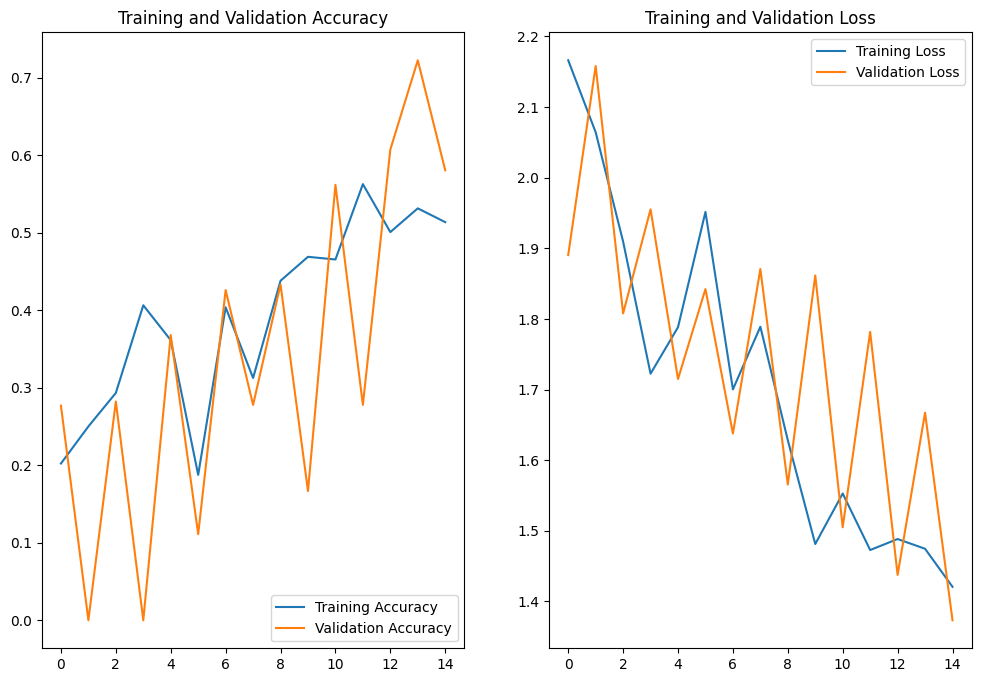

In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the training history
plot_training_history(history)
